# Классификация вина

Выполним все те же самые шаги

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")
matplotlib.style.use('seaborn-pastel')

Загрузим датасет и посмотрим на данные.

- `fixed acidity` - фиксированная кислотность
- `volatile acidity` - летучая кислотность
- `citric acid` - лимонная кислота
- `residual sugar` - остаточный сахар
- `chlorides` - хлориды
- `free sulfur dioxide` - свободный диоксид серы
- `total sulfur dioxide` - диоксид серы общий
- `density` - плотность
- `pH` - рН
- `sulphates` - сульфаты
- `alcohol` - алкоголь
- `quality` - качество (оценка от 0 до 10), выходная переменная

In [2]:
df = pd.read_csv(
    "lesson_20_08/winequality-white.csv", delimiter=';'
)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
df.profile_report()

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

<AxesSubplot:xlabel='quality', ylabel='count'>

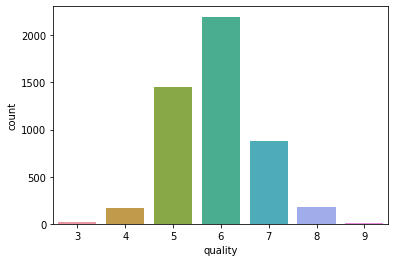

In [3]:
sns.countplot(x="quality", data=df)

In [4]:
sns.pairplot(df, hue="quality")

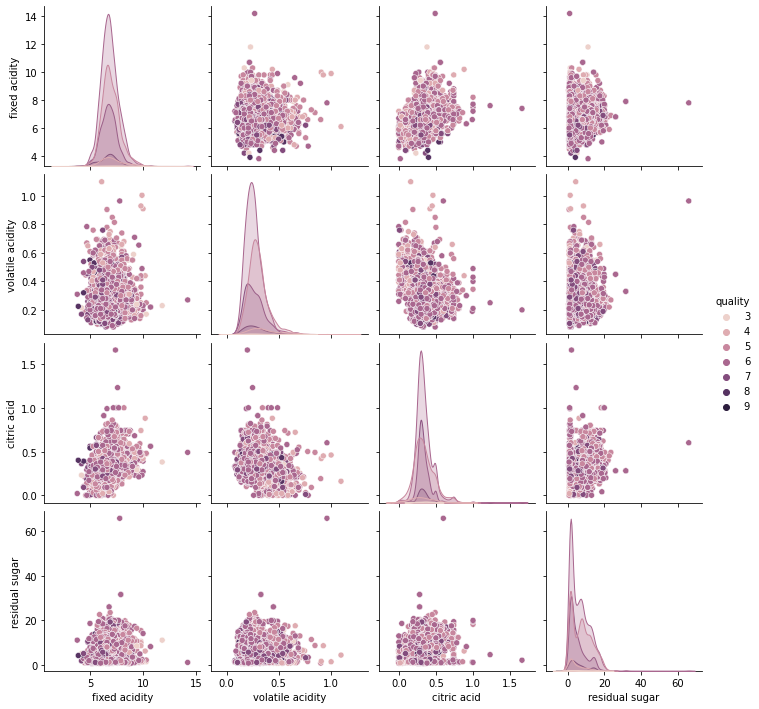

In [4]:
sns.pairplot(
    df[
        [
            'fixed acidity', 'volatile acidity',
            'citric acid', 'residual sugar',
            'quality'
        ]
    ],
    hue="quality"
)

<AxesSubplot:>

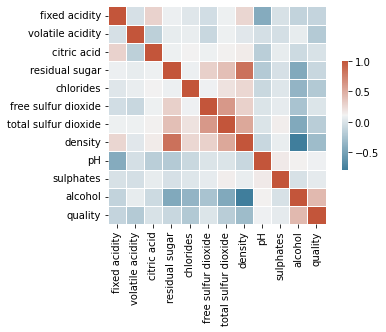

In [5]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# square - квадратные ячейки
# linewidths - ширина линий, разделяющих ячейки
# shrink - ширина цветовой полосы
sns.heatmap(
    df.corr(), cmap=cmap,
    square=True, linewidths=.5, cbar_kws={"shrink": .5}
)

Подготовимся к обучению. Здесь у нас нет заранее разделенных выборок.
Сделаем это сами.

In [6]:
x = df.copy()
y = df['quality']
del x['quality']

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x, y, random_state=42, train_size=0.8, stratify=y, shuffle=True
)

In [ ]:
x_train.info()

In [ ]:
x_val.shape

In [ ]:
x_val.info()

#### Дерево решений

https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

Оценивать будем по 

https://habr.com/ru/company/ods/blog/328372/

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
tree_baseline = DecisionTreeClassifier()
tree_baseline.fit(x_train, y_train)

y_train_predicted_tree = tree_baseline.predict_proba(x_train)
y_val_predicted_tree = tree_baseline.predict_proba(x_val)

roc_tree_train = roc_auc_score(y_train, y_train_predicted_tree, multi_class='ovr')
roc_tree_val = roc_auc_score(y_val, y_val_predicted_tree, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_tree_train}")
print(f"ROC AUC на тестовой {roc_tree_val}")

ROC AUC на обучающей 1.0
ROC AUC на тестовой 0.6439583257808529


In [11]:
roc_tree_train = roc_auc_score(y_train, y_train_predicted_tree, multi_class='ovo')
roc_tree_val = roc_auc_score(y_val, y_val_predicted_tree, multi_class='ovo')

print(f"ROC AUC на обучающей {roc_tree_train}")
print(f"ROC AUC на тестовой {roc_tree_val}")

ROC AUC на обучающей 1.0
ROC AUC на тестовой 0.6349631718510584


Text(0.5, 0, 'Предсказанные значения')

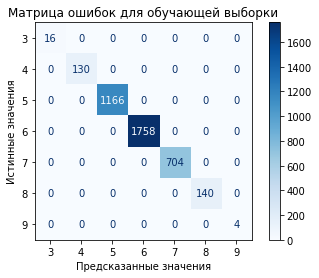

In [12]:
display = ConfusionMatrixDisplay.from_estimator(
    tree_baseline,
    x_train,
    y_train,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для обучающей выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

Text(0.5, 0, 'Предсказанные значения')

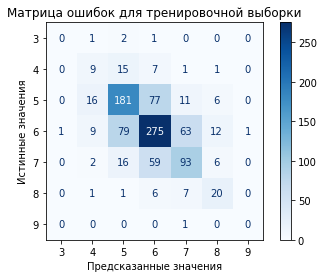

In [13]:
display = ConfusionMatrixDisplay.from_estimator(
    tree_baseline,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

In [ ]:
_ = plot_tree(
    tree_baseline,
    # feature_names=x.columns,
    # class_names=y.unique(),
    filled=True
)

Произошло переобучение. Попробуем избавиться от него.

In [14]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_train, y_train)

y_train_predicted_tree = tree.predict_proba(x_train)
y_val_predicted_tree = tree.predict_proba(x_val)

roc_tree_train = roc_auc_score(y_train, y_train_predicted_tree, multi_class='ovr')
roc_tree_val = roc_auc_score(y_val, y_val_predicted_tree, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_tree_train}")
print(f"ROC AUC на тестовой {roc_tree_val}")

ROC AUC на обучающей 0.7194043748451692
ROC AUC на тестовой 0.7242619187237748


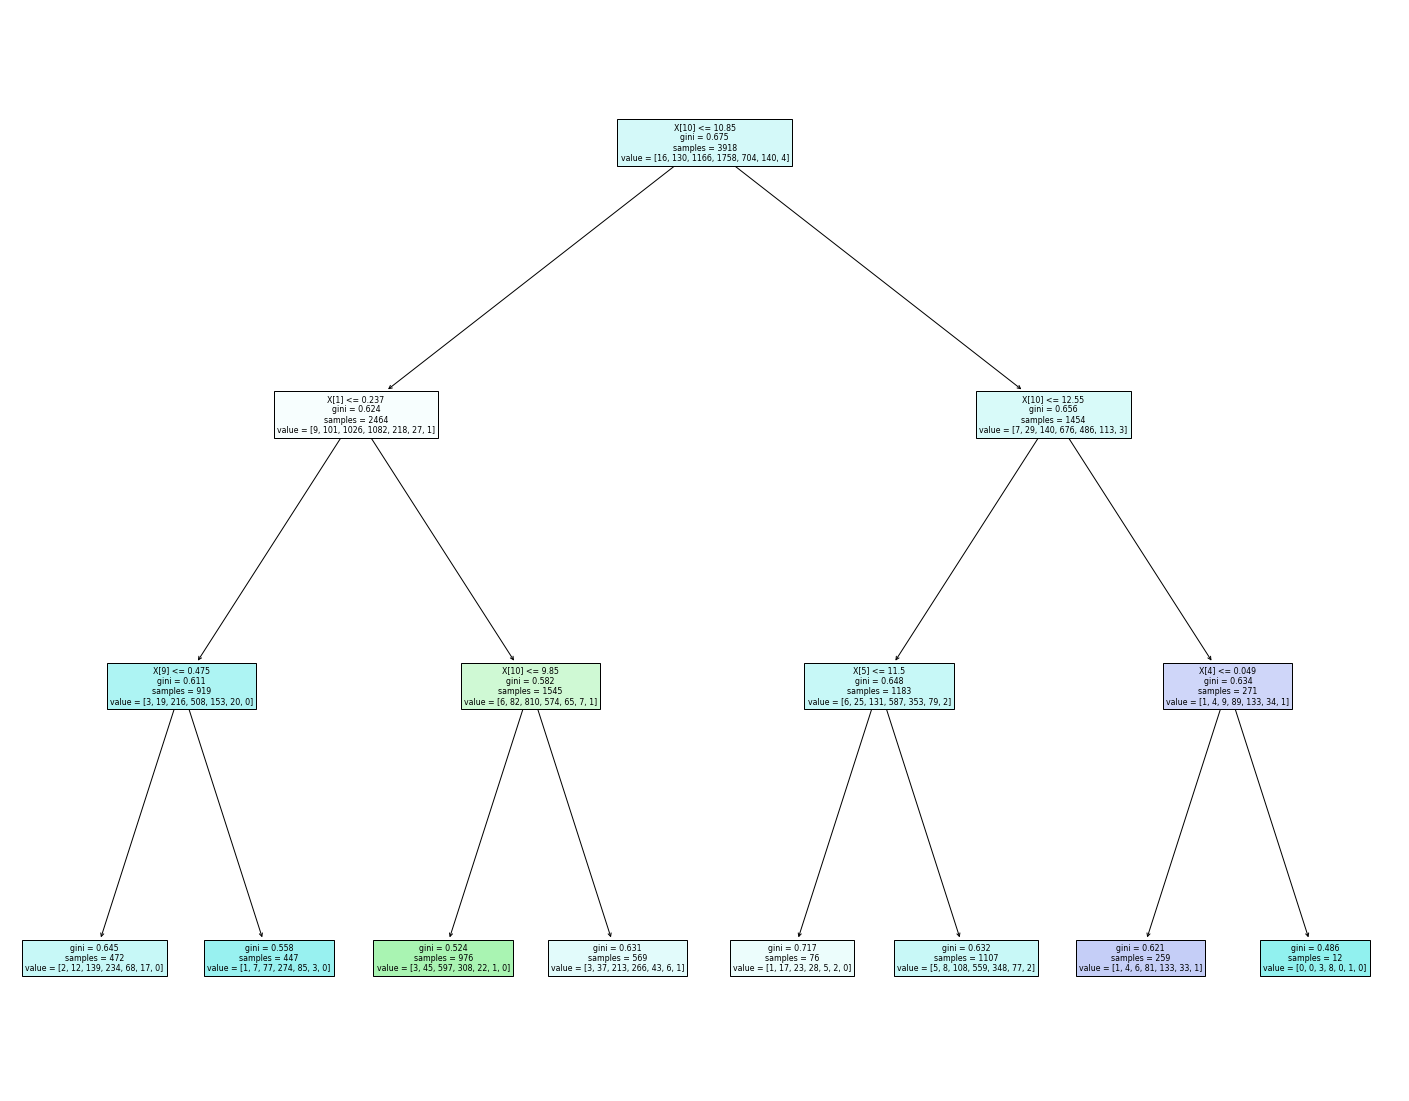

In [15]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(
    tree,
    # feature_names=x.columns,
    # class_names=y.unique(),
    filled=True
)

In [16]:
print(export_text(tree))

|--- feature_10 <= 10.85
|   |--- feature_1 <= 0.24
|   |   |--- feature_9 <= 0.47
|   |   |   |--- class: 6
|   |   |--- feature_9 >  0.47
|   |   |   |--- class: 6
|   |--- feature_1 >  0.24
|   |   |--- feature_10 <= 9.85
|   |   |   |--- class: 5
|   |   |--- feature_10 >  9.85
|   |   |   |--- class: 6
|--- feature_10 >  10.85
|   |--- feature_10 <= 12.55
|   |   |--- feature_5 <= 11.50
|   |   |   |--- class: 6
|   |   |--- feature_5 >  11.50
|   |   |   |--- class: 6
|   |--- feature_10 >  12.55
|   |   |--- feature_4 <= 0.05
|   |   |   |--- class: 7
|   |   |--- feature_4 >  0.05
|   |   |   |--- class: 6



Text(0.5, 0, 'Предсказанные значения')

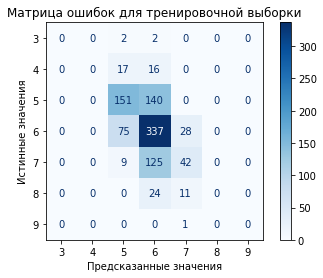

In [17]:
display = ConfusionMatrixDisplay.from_estimator(
    tree,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

Попробуем автоматически подобрать лучшие параметры

In [18]:
from sklearn.model_selection import GridSearchCV

In [20]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9],
    'min_samples_split': [4, 8, 16, 32, 64],
}

In [21]:
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)

clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9],
                         'min_samples_split': [4, 8, 16, 32, 64]})

In [22]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 4}

In [23]:
best_tree = clf.best_estimator_

In [24]:
y_train_predicted_tree = best_tree.predict_proba(x_train)
y_val_predicted_tree = best_tree.predict_proba(x_val)

roc_tree_train = roc_auc_score(y_train, y_train_predicted_tree, multi_class='ovr')
roc_tree_val = roc_auc_score(y_val, y_val_predicted_tree, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_tree_train}")
print(f"ROC AUC на тестовой {roc_tree_val}")

ROC AUC на обучающей 0.8955911849385426
ROC AUC на тестовой 0.6340094676599336


In [ ]:
display = ConfusionMatrixDisplay.from_estimator(
    best_tree,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

In [ ]:
_ = plot_tree(
    best_tree,
    # feature_names=x.columns,
    # class_names=y.unique(),
    filled=True
)

### Ансамбли

Теперь попробуем что-то более сложное:
- случайный лес (бэггинг/усреднение)
- градиентный бустинг (на основе деревьев)

https://ru.wikipedia.org/wiki/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3

https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3

https://habr.com/ru/post/561732/

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#### Случайный лес

In [2]:
r_forest = RandomForestClassifier()
r_forest.fit(x_train, y_train)

y_train_predicted = r_forest.predict_proba(x_train)
y_val_predicted = r_forest.predict_proba(x_val)

roc_train = roc_auc_score(y_train, y_train_predicted, multi_class='ovr')
roc_val = roc_auc_score(y_val, y_val_predicted, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_train}")
print(f"ROC AUC на тестовой {roc_val}")

NameError: name 'x_train' is not defined

In [ ]:
display = ConfusionMatrixDisplay.from_estimator(
    r_forest,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

In [ ]:
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 6, 10],
}
roc_auc_ovr = make_scorer(roc_auc_score, multi_class='ovr')

clf = GridSearchCV(
    RandomForestClassifier(), parameters, cv=5, scoring=roc_auc_ovr
)

clf.fit(x_train, y_train)

print(f'Лучшие параметры: {clf.best_params_}')

best_r_tree = clf.best_estimator_

In [29]:
y_train_predicted = best_r_tree.predict_proba(x_train)
y_val_predicted = best_r_tree.predict_proba(x_val)

roc_train = roc_auc_score(y_train, y_train_predicted, multi_class='ovr')
roc_val = roc_auc_score(y_val, y_val_predicted, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_train}")
print(f"ROC AUC на тестовой {roc_val}")

ROC AUC на обучающей 0.8547872267946275
ROC AUC на тестовой 0.7310035061530515


Text(0.5, 0, 'Предсказанные значения')

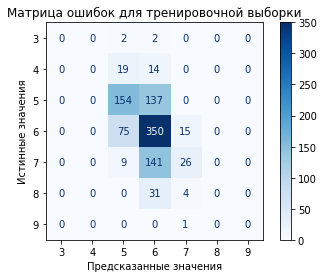

In [30]:
display = ConfusionMatrixDisplay.from_estimator(
    best_r_tree,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

#### Градиентный бустинг

In [31]:
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

y_train_predicted = clf.predict_proba(x_train)
y_val_predicted = clf.predict_proba(x_val)

roc_train = roc_auc_score(y_train, y_train_predicted, multi_class='ovr')
roc_val = roc_auc_score(y_val, y_val_predicted, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_train}")
print(f"ROC AUC на тестовой {roc_val}")

ROC AUC на обучающей 0.9415092164821689
ROC AUC на тестовой 0.6652734511413193


Text(0.5, 0, 'Предсказанные значения')

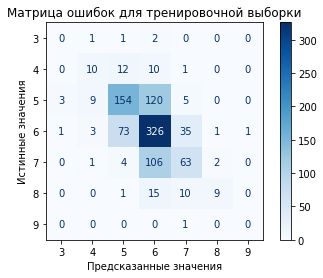

In [32]:
display = ConfusionMatrixDisplay.from_estimator(
    clf,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

#### Стекинг

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [34]:
estimators = [
    (
        'rf', RandomForestClassifier(
            n_estimators=50, max_depth=3, random_state=42
        )
    ),
    (
        'svr', make_pipeline(
            StandardScaler(),
            LinearSVC(random_state=42)
        )
    )
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(
        n_estimators=50,
        max_depth=3,
        random_state=42
    )
)

clf.fit(x_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=3,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=RandomForestClassifier(max_depth=3,
                                                          n_estimators=50,
                                                          random_state=42))

In [35]:
y_train_predicted = clf.predict_proba(x_train)
y_val_predicted = clf.predict_proba(x_val)

roc_train = roc_auc_score(y_train, y_train_predicted, multi_class='ovo')
roc_val = roc_auc_score(y_val, y_val_predicted, multi_class='ovo')

print(f"ROC AUC на обучающей {roc_train}")
print(f"ROC AUC на тестовой {roc_val}")

ROC AUC на обучающей 0.7956918950978575
ROC AUC на тестовой 0.7694943492606541


Text(0.5, 0, 'Предсказанные значения')

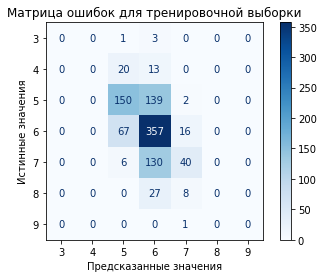

In [36]:
display = ConfusionMatrixDisplay.from_estimator(
    clf,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

Что делать?

In [37]:
sorted(df['quality'].unique())

[3, 4, 5, 6, 7, 8, 9]

In [38]:
df['quality'].replace(
    {
        3: 'Низкое',
        4: 'Низкое',
        5: 'Низкое',
        6: 'Среднее',
        7: 'Высокое',
        8: 'Высокое',
        9: 'Высокое',
    }, inplace=True
)

<AxesSubplot:xlabel='quality', ylabel='count'>

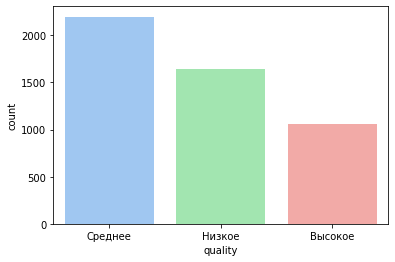

In [39]:
sns.countplot(x="quality", data=df)

In [40]:
new_x = df.copy()
new_y = df['quality']
del new_x['quality']

x_train, x_val, y_train, y_val = train_test_split(
    new_x, new_y, random_state=42, train_size=0.8, stratify=y, shuffle=True
)

In [41]:
forest = RandomForestClassifier(max_depth=3, min_samples_split=4)
forest.fit(x_train, y_train)

y_train_predicted = forest.predict_proba(x_train)
y_val_predicted = forest.predict_proba(x_val)

roc_train = roc_auc_score(y_train, y_train_predicted, multi_class='ovr')
roc_val = roc_auc_score(y_val, y_val_predicted, multi_class='ovr')

print(f"ROC AUC на обучающей {roc_train}")
print(f"ROC AUC на тестовой {roc_val}")

ROC AUC на обучающей 0.768312691949491
ROC AUC на тестовой 0.7415546980905859


Text(0.5, 0, 'Предсказанные значения')

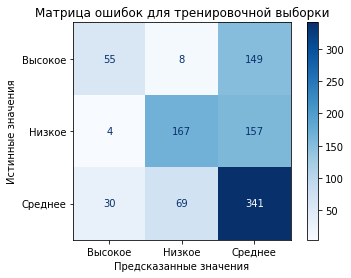

In [42]:
display = ConfusionMatrixDisplay.from_estimator(
    forest,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')

In [46]:
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 6, 10],
}
# roc_auc_ovr = make_scorer(roc_auc_score, multi_class='ovr')

clf = GridSearchCV(
    RandomForestClassifier(), parameters, cv=5, scoring='f1'
)

clf.fit(x_train, y_train)

print(f'Лучшие параметры: {clf.best_params_}')

best_r_tree = clf.best_estimator_

Лучшие параметры: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [56]:
from sklearn.metrics import precision_recall_fscore_support

In [64]:
y_train_predicted = best_r_tree.predict(x_train)
y_val_predicted = best_r_tree.predict(x_val)

precision, recall, fscore, _ = precision_recall_fscore_support(y_train, y_train_predicted)
precision_val, recall_val, fscore_val, _ = precision_recall_fscore_support(y_val, y_val_predicted)

print(f"precision на обучающей {precision}")
print(f"recall на обучающей {recall}")
print(f"fscore на обучающей {fscore}")
print(f"Метрики на тестовой {precision_val}, {recall_val}, {fscore_val}")

precision на обучающей [0.67494357 0.69384359 0.5675319 ]
recall на обучающей [0.35259434 0.63567073 0.7337884 ]
fscore на обучающей [0.46320682 0.66348449 0.64003969]
Метрики на тестовой [0.60176991 0.70609319 0.55102041], [0.32075472 0.60060976 0.73636364], [0.41846154 0.6490939  0.63035019]


In [59]:
y_train_predicted

array([[0.06295496, 0.55875699, 0.37828805],
       [0.05511974, 0.60338438, 0.34149588],
       [0.11341052, 0.45727618, 0.42931329],
       ...,
       [0.25485138, 0.23389014, 0.51125848],
       [0.05546284, 0.60932338, 0.33521378],
       [0.47231427, 0.09639174, 0.43129399]])

Text(0.5, 0, 'Предсказанные значения')

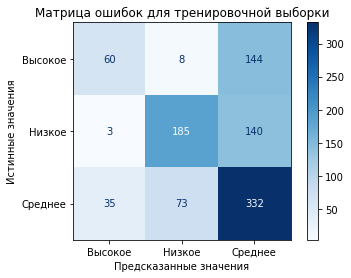

In [45]:
display = ConfusionMatrixDisplay.from_estimator(
    best_r_tree,
    x_val,
    y_val,
    cmap=plt.cm.Blues,
)
display.ax_.set_title('Матрица ошибок для тренировочной выборки')
display.ax_.set_ylabel('Истинные значения')
display.ax_.set_xlabel('Предсказанные значения')